In [247]:
# Step 1: Import libraries
import pandas as pd
import math
import numpy as np
# Step 4: Plot the data using Matplotlib or Seaborn
import matplotlib.pyplot as plt
import seaborn as sns 

# Step 2: Load the CSV data
file_path = 'Users/tim/Documents/GitHub/The-Running-Machine/Script/RunningData.csv'  # Replace with your actual file path 
# Specify the filename
filename = 'RunningData.csv'  # replace with your actual CSV file name

# Read the CSV file into a DataFrame
try:
    df = pd.read_csv(filename)
    print(df.head())  # Print the first few rows to check if data is loaded correctly
except pd.errors.EmptyDataError:
    print("The file is empty or could not be read.")
except FileNotFoundError:
    print("The file was not found. Please check the file name and path.")
except Exception as e:
    print(f"An error occurred: {e}") 

# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip() 

# Define the cleaning function
def clean_time_format(time_str):
    if pd.isna(time_str):
        return time_str  # Return NaN as is
    parts = time_str.split(':')
    # If there are only two components (mm:ss), add "00:" in front
    if len(parts) == 2:
        return f"00:{time_str}"
    # If there are three components (hh:mm:ss), return as is
    return time_str

# Apply the cleaning function to the 'Time' column
df['Cleaned Time'] = df['Time'].apply(clean_time_format)

# Create a new column for Total Seconds
def calculate_total_seconds(time_str):
    if pd.isna(time_str):
        return None  # Return None for NaN
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

# Apply the function to create the Total Seconds column
df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

# Check the DataFrame with the new columns
print(df[['Time', 'Cleaned Time', 'Total Seconds']]) 

df.reset_index(drop=True, inplace=True)

# Step 2: Convert necessary columns to appropriate data types
df['Distance'] = df['Distance'].str.replace(' mi', '').astype(float)
df['Heart Rate'] = df['Heart Rate'].astype(int)

  Sport             Date                                     Title     Time  \
0   Run  Sat, 10/19/2024                                  GINOBILI  2:55:56   
1   Run  Thu, 10/17/2024                                   Slumped  1:02:49   
2   Run  Wed, 10/16/2024  Err, like hop, I hopped out like wassup?  1:19:11   
3   Run  Tue, 10/15/2024                                 Lunch Run    50:01   
4   Run  Tue, 10/15/2024                                   warm up    14:23   

  Distance  Elevation  Heart Rate  Pace   
0  20.01 mi    460 ft         162    NaN  
1   7.25 mi    134 ft         163    NaN  
2  10.27 mi    237 ft         174    NaN  
3   6.08 mi    154 ft         163    NaN  
4   1.64 mi     35 ft         148    NaN  
        Time Cleaned Time  Total Seconds
0    2:55:56      2:55:56          10556
1    1:02:49      1:02:49           3769
2    1:19:11      1:19:11           4751
3      50:01     00:50:01           3001
4      14:23     00:14:23            863
..       ...         

In [248]:
# Step 3: Calculate Pace in seconds per mile
df['Pace (sec/mile)'] = df['Total Seconds'] / df['Distance']

# Function to convert seconds to mm:ss format
def convert_seconds_to_pace(seconds):
    if pd.isna(seconds) or seconds == float('inf') or seconds == float('-inf'):  # Check for NaN, inf, or -inf
        return None  # Return None for invalid values
    mins = seconds // 60  
    secs = float((math.trunc(seconds % 60))/100)

    t = mins + secs 

    return t


# Function to update pace in the DataFrame and check for invalid values
def update_pace_column(df, pace_column):
    count_invalid = 0  # Counter for invalid values
    invalid = 0
    for index in range(len(df)):
        pace_value = df.at[index, pace_column]
        converted_pace = convert_seconds_to_pace(pace_value)
        
        # Update the Pace column
        df.at[index, 'Pace'] = converted_pace
        
        # Check if the converted pace is greater than 10 seconds per mile
        if converted_pace is not None and converted_pace > 12:
            count_invalid += 1 
            mins = converted_pace // 60  
            secs = float((math.trunc(converted_pace % 60))/100)
            t = mins + secs 
          
            # Update the Pace column
            df.at[index, 'Pace'] = t

        value = df.at[index, 'Pace'] 
        if value is not None and value > 12:
            invalid += 1
            print(value)
    

    return invalid

# Example usage
# Replace 'Pace (sec/mile)' with your actual column name
invalid = update_pace_column(df, 'Pace (sec/mile)') 


print(df['Pace'].loc[40:80])
print(invalid)




12.22
40     8.34
41     8.50
42     8.07
43     9.00
44     8.40
45     9.43
46     8.38
47    10.42
48     8.51
49     9.10
50     8.51
51     8.59
52     9.26
53     9.19
54     9.03
55     9.52
56     9.25
57     9.33
58    10.02
59     9.38
60     9.10
61     9.15
62     9.52
63    10.00
64     9.48
65     9.29
66    10.19
67     9.38
68     9.13
69     9.41
70     8.51
71     8.05
72     8.58
73     8.30
74     9.07
75     9.46
76     7.52
77     8.29
78     9.46
79    10.04
80     9.18
Name: Pace, dtype: float64
1


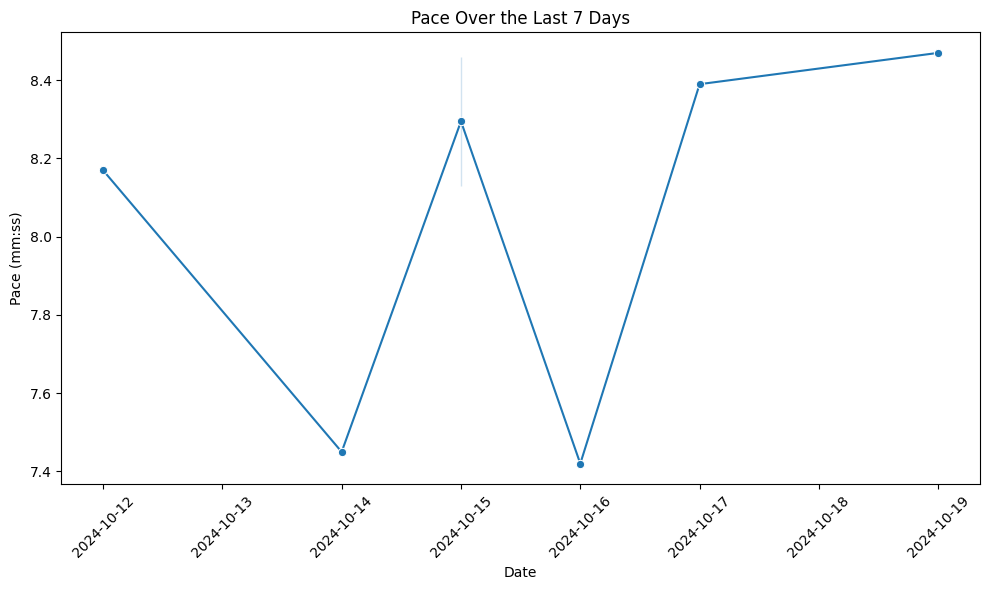

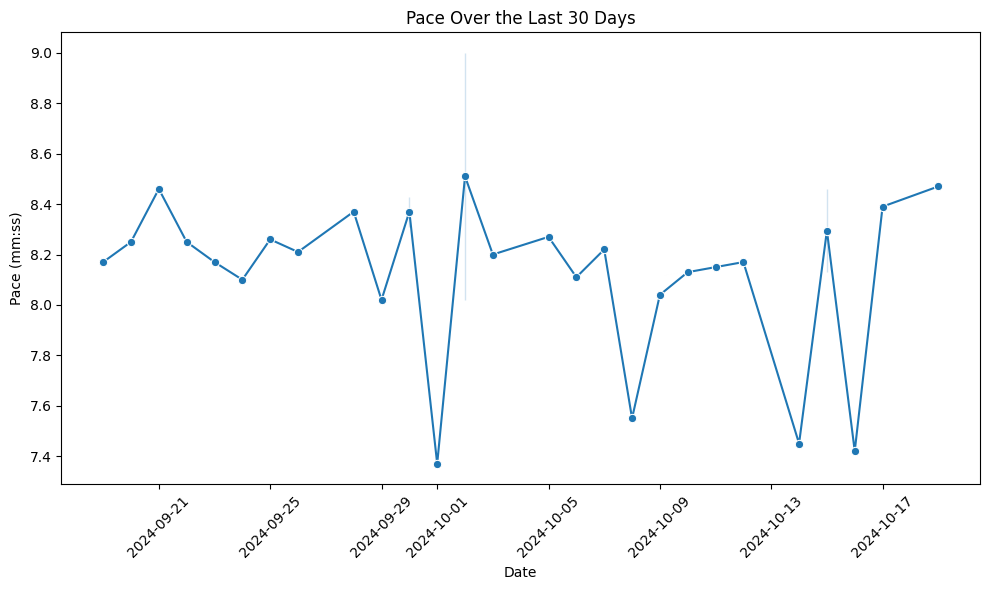

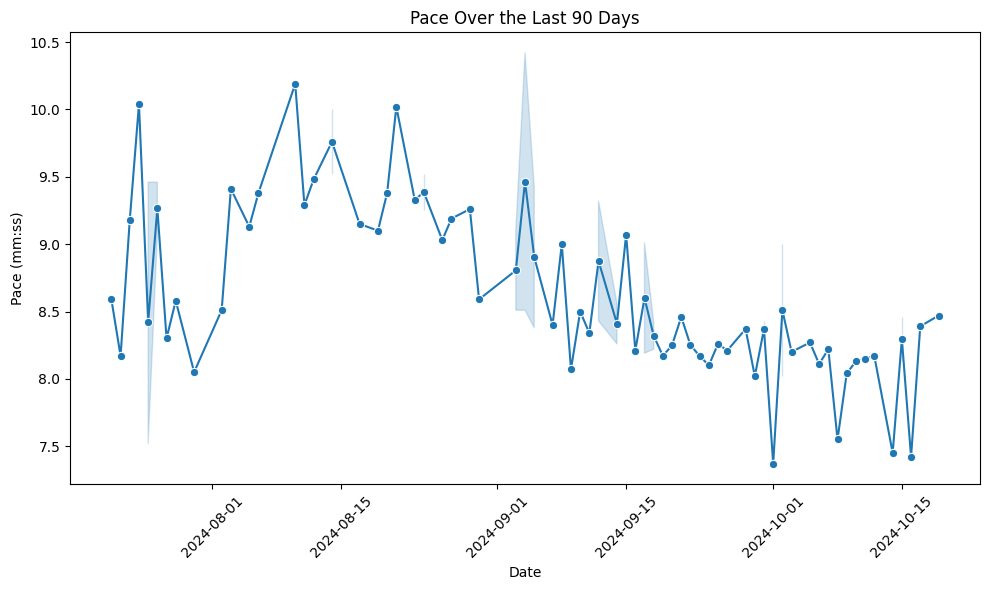

  Sport       Date                                     Title     Time  \
6   Run 2024-10-12                   Give Life Back To Music  1:48:45   
5   Run 2024-10-14                                  SMUCKERS  1:05:59   
4   Run 2024-10-15                                   warm up    14:23   
3   Run 2024-10-15                                 Lunch Run    50:01   
2   Run 2024-10-16  Err, like hop, I hopped out like wassup?  1:19:11   
1   Run 2024-10-17                                   Slumped  1:02:49   
0   Run 2024-10-19                                  GINOBILI  2:55:56   

   Distance Elevation  Heart Rate  Pace Cleaned Time  Total Seconds  \
6     13.11    274 ft         167  8.17      1:48:45           6525   
5      8.50    205 ft         173  7.45      1:05:59           3959   
4      1.64     35 ft         148  8.46     00:14:23            863   
3      6.08    154 ft         163  8.13     00:50:01           3001   
2     10.27    237 ft         174  7.42      1:19:11        

In [249]:
# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

# 1. Pace Over the Last 7 Days
last_7_days = filter_last_days(df, 7)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace', data=last_7_days, marker='o')
plt.title('Pace Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Pace Over the Last 30 Days
last_30_days = filter_last_days(df, 30)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace', data=last_30_days, marker='o')
plt.title('Pace Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Pace Over the Last 90 Days
last_90_days = filter_last_days(df, 90)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace', data=last_90_days, marker='o')
plt.title('Pace Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(last_7_days)

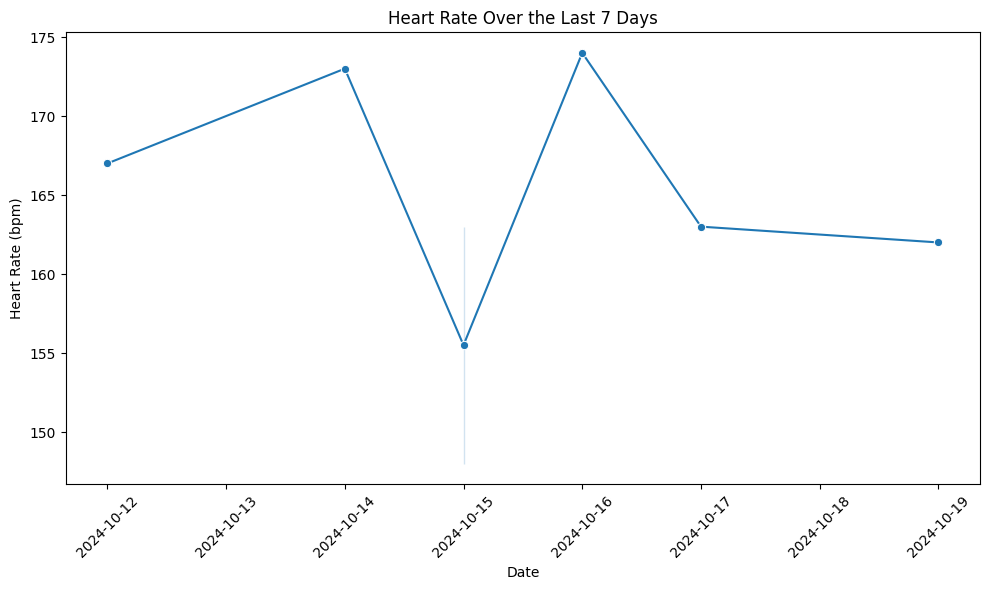

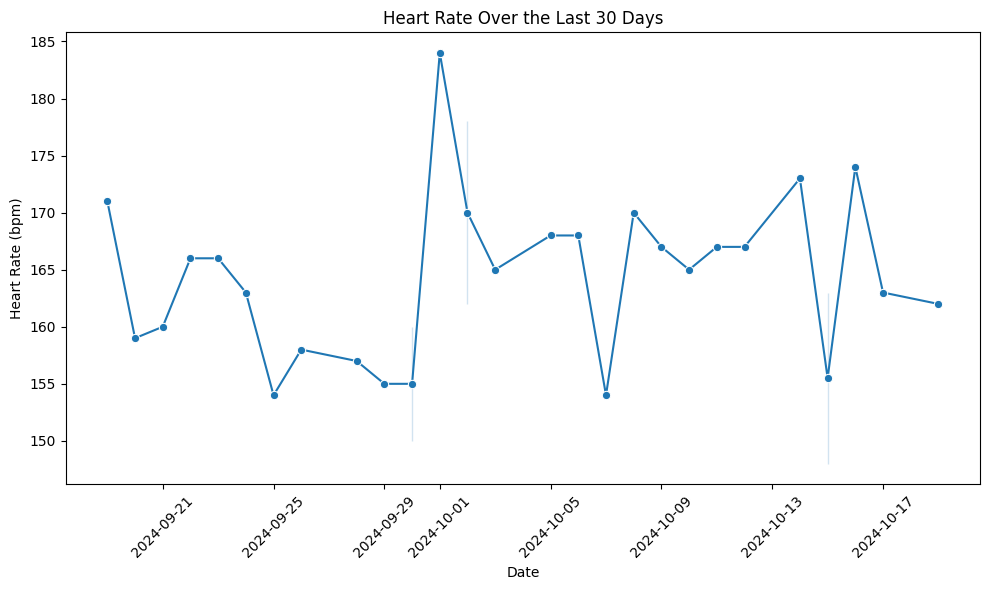

In [250]:
# 1. Heart Rate Over the Last 7 Days
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Heart Rate', data=last_7_days, marker='o')
plt.title('Heart Rate Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Heart Rate Over the Last 30 Days
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Heart Rate', data=last_30_days, marker='o')
plt.title('Heart Rate Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


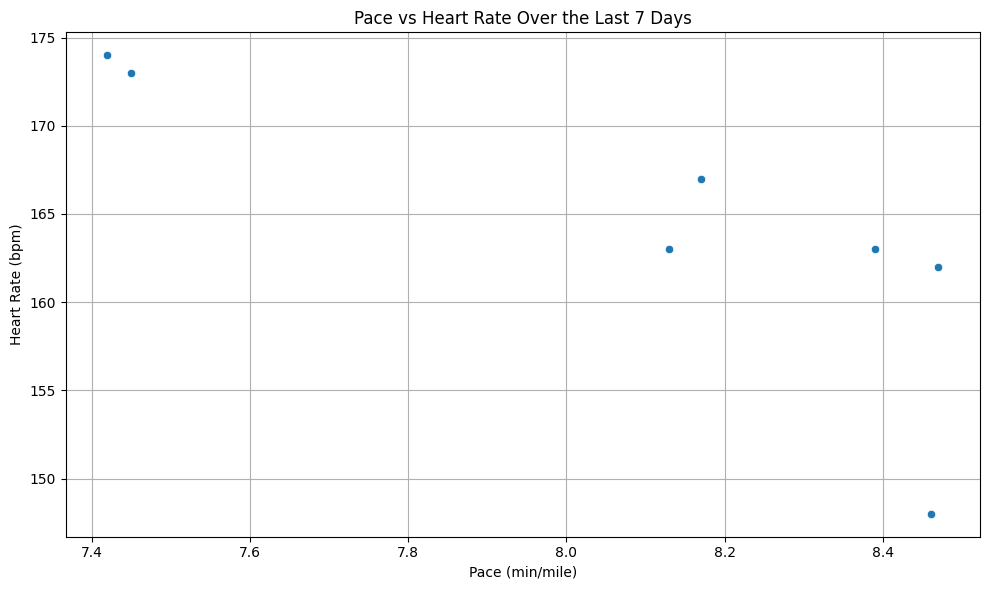

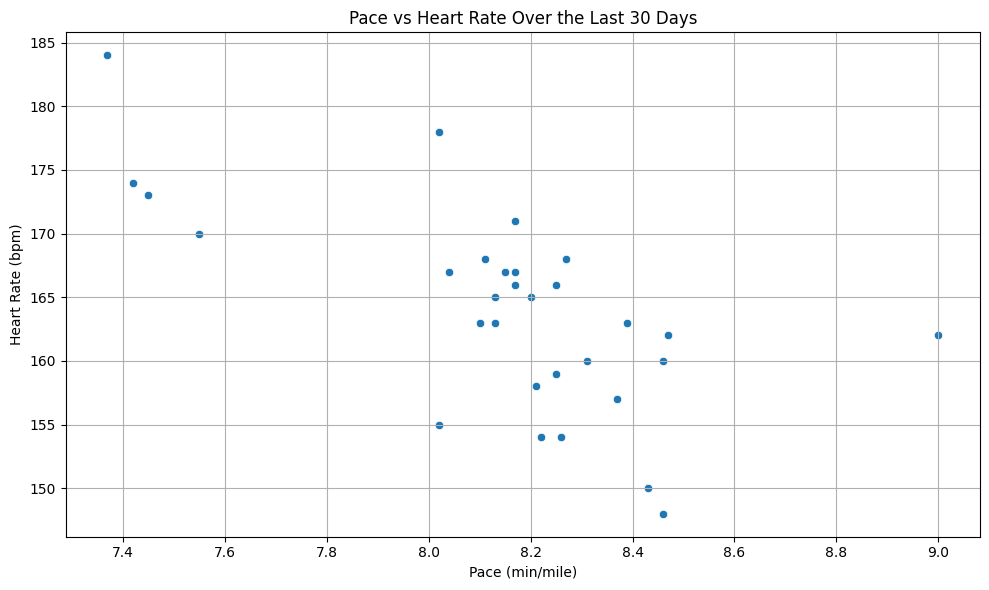

In [251]:
# Scatter Plot: Pace vs Heart Rate for the Last 7 Days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pace', y='Heart Rate', data=last_7_days)
plt.title('Pace vs Heart Rate Over the Last 7 Days')
plt.xlabel('Pace (min/mile)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Pace vs Heart Rate for the Last 30 Days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pace', y='Heart Rate', data=last_30_days)
plt.title('Pace vs Heart Rate Over the Last 30 Days')
plt.xlabel('Pace (min/mile)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show()


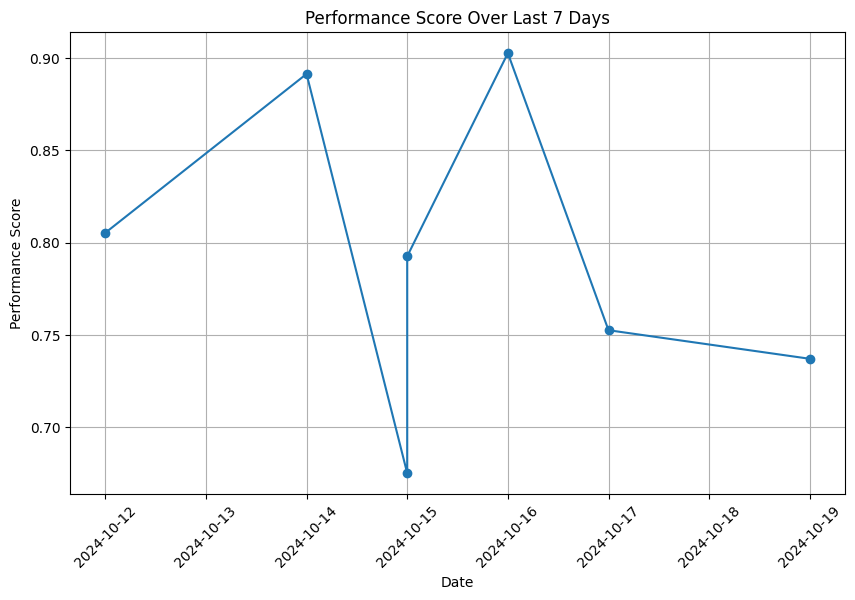

/var/folders/kf/h_cypk6j471_7p8g3mlk7tyh0000gn/T/ipykernel_8485/2316190712.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_7_days['Performance Score'] = last_7_days.apply(


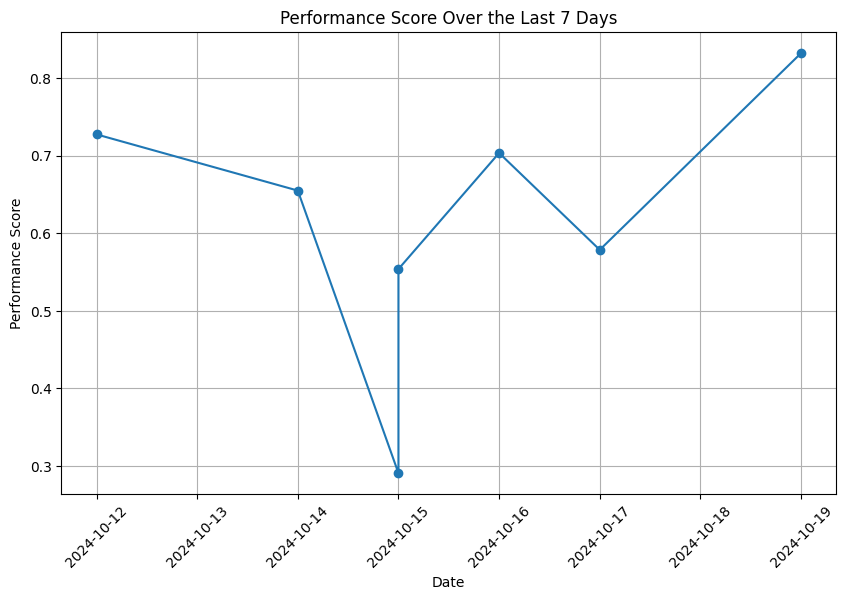

In [258]:
# Step 1: Calculate Performance Metric
df['Performance Score'] = 2.4 * (df['Heart Rate'] / df['Pace (sec/mile)'])

# Step 2: Filter the last 7, 30, and 90 days
last_7_days = df.tail(7)
last_30_days = df.tail(30)

# Plot for the last 7 days
plt.figure(figsize=(10, 6))
plt.plot(last_7_days['Date'], last_7_days['Performance Score'], marker='o')
plt.title('Performance Score Over Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Performance Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Adjusted performance score function to include distance
def calculate_performance_score(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0:
        return None  # Handle division by zero
    # Factor in distance with log scaling
    performance_score = 500 * (1 / pace) * (1 / heart_rate) * (np.log(distance + 1) * 0.75)
    return performance_score 

# Apply the performance score function to the past 7 days
last_7_days['Performance Score'] = last_7_days.apply(
    lambda row: calculate_performance_score(row['Pace'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the performance score for the past 7 days
plt.figure(figsize=(10, 6))
plt.plot(last_7_days['Date'], last_7_days['Performance Score'], marker='o')
plt.title('Performance Score Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Performance Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot for the last 30 days
# plt.figure(figsize=(10, 6))
# plt.plot(last_30_days['Date'], last_30_days['Performance Score'], marker='o')
# plt.title('Performance Score Over Last 30 Days')
# plt.xlabel('Date')
# plt.ylabel('Performance Score')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.show()